<img src="pnda1r-trans.png" width=256>

## Anomaly detection in network telemetry using red PNDA
#### v1.0

#### Copyright © 2018 Cisco Systems, Inc. All Rights Reserved.

This notebook is an Python implementation of a simple mu-sigma-based detection algorithm to identify packet losses in XR telemetry data captured from a simple multiple host topology. Such packet losses are often indications of unintentional black-holing of traffic.

Note the following ETL (extract-transform-load) assumes the source telemetry is encapsulated as snappy-compressed avro files.

## The learning objectives

* Farmilarization with the Jupyter Notebook interface
* Working with Spark RDDs, Pandas and Scipy packages in Python
* Visualization using Matplotlib package
* Understand how a simple statiscal approach can be implemented, evaluated and applied to network telemetry

## What we won't cover

* Although we're running the notebook here on red-PNDA, this Python code could also be deployed as a platform application on PNDA...however that is another tutorial ;-)

## The data

In this exercise, we'll use a time-series-based telemetry data set collected from a VIRL (Virtual Internet Routing Lab) simulation.
This should be stored on this path: ./telemetry_data/

Here's a sample of what the input looks like:

    {u'timestamp': 1517445006000, u'rawdata': '{"metric":"interface.packets-received","value":"0","timestamp":"1517445006325","tags":{"interface-name":"GigabitEthernet0/0/0/4","host":"IOS-xrv9k-2"}}', u'host_ip': u'127.0.0.1', u'src': u'timeseries'}
    
    {u'timestamp': 1517445006000, u'rawdata': '{"metric":"interface.packets-sent","value":"0","timestamp":"1517445006325","tags":{"interface-name":"GigabitEthernet0/0/0/6","host":"IOS-xrv9k-2"}}', u'host_ip': u'127.0.0.1', u'src': u'timeseries'}

## How to run the code

To run the code below:

* Click on the cell to select it.
* Using SHIFT+ENTER on your keyboard or press the play button ( ) in the toolbar above.
* When a cell is running, [*] is shown on the left-hand side...once execution has completed, it will contain a number with any output or errors shown below the code cell
* To run all cells in one go, select the Run menu in Jupyter and then Run All Cells option

## How to view the output in Grafana

red-PNDA provisions Grafana so the output of this notebook can be interactively viewed there too:

* Navigate to Grafana from your PNDA console main page (`http://<your-ip\>:3000`). If it asks for credentials, enter pnda/pndapnda 
* Load the 'Anomaly-Detection' dashboard to view the blackhole detection output (`http://<your-ip\>:3000/dashboard/db/anomaly-detection?orgId=1`)
* Load the 'Pkt Received/Sent' dashboard to view the packets received/sent on the host (`http://<your-ip>:3000/dashboard/db/anomaly-detection?orgId=1`)

### Start of Notebook

In [85]:
# Output flags
DEBUG = False
SAVE_CSV = False
PLOT = True
SAVE_PLOT = False
NOTEBOOK_PLOT = True

Set the SPARK_HOME environment variable, by default on red-pnda it is in `/usr/local/spark`

In [86]:
import os
os.environ['SPARK_HOME'] = '/usr/local/spark'

In [87]:
import findspark
findspark.init()
import pandas as pd
import numpy as np
from scipy import stats
from scipy.signal import butter, lfilter, freqz, filtfilt
import json
import matplotlib.pyplot as plt
import datetime

OpenTSDB endpoint for the telemetry input and black-hole detection output

In [88]:
#OpenTSDB_url = None
OpenTSDB_url = 'http://localhost:4242/api/put'

Source metrics are captured from the VIRL-based test topology via Pipeline (see https://github.com/cisco/bigmuddy-network-telemetry-pipeline) and are saved as Avro-encoded, snappy-compressed files....so we need the python support for both fastavro and snappy to be pre-installed in our (virtual) environment

In [89]:
import fastavro
import snappy
from io import BytesIO
import pyspark

try:
    sc
except NameError:
    sc = pyspark.SparkContext()
else:
    if sc != None:
        sc.stop()
    sc = pyspark.SparkContext()

Convenience functions to convert from avro to pandas dataframe - from
http://pythonexample.com/code/python-avro-pandas/

In [90]:
def avro_df(filepath, encoding):
    # Open file stream
    with open(filepath, encoding) as fp:
        # Configure Avro reader
        reader = fastavro.reader(fp)
        # Retrieve the schema
        #schema = reader.schema
        # Load records in memory
        records = [r for r in reader]
        # Populate pandas.DataFrame with records
        df = pd.DataFrame.from_records(records)
        # Return created DataFrame
        return df

In [91]:
def avro_schema(filepath, encoding):
    # Open file stream
    with open(filepath, encoding) as fp:
        # Configure Avro reader
        reader = fastavro.reader(fp)
        # Retrieve the schema
        schema = reader.schema
        return schema

Convenience function for turning JSON strings into a dataframe

In [92]:
def jsonToDataFrame(json, schema=None):
    # SparkSessions are available with Spark 2.0+
    reader = sc.read
    if schema:
        reader.schema(schema)
    return reader.json(sc.parallelize([json]))

User-defined functions for metric processing where we flatten nested json keys into a seperate column which will be easier for us to analyze.

In [93]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType, LongType

def packets_recv_func(val, metric):
    if metric == 'interface.packets-received':
        return long(val)
    else:
        return 0

def packets_sent_func(val, metric):
    if metric == 'interface.packets-sent':
        return long(val)
    else:
        return 0

def multicast_packets_recv_func(val, metric):
    if metric == 'interface.multicast-packets-received':
        return long(val)
    else:
        return 0    

def multicast_packets_sent_func(val, metric):
    if metric == 'interface.multicast-packets-sent':
        return long(val)
    else:
        return 0  

def broadcast_packets_recv_func(val, metric):
    if metric == 'interface.broadcast-packets-received':
        return long(val)
    else:
        return 0 

def broadcast_packets_sent_func(val, metric):
    if metric == 'interface.broadcast-packets-sent':
        return long(val)
    else:
        return 0  

def bytes_in_func(val, metric):
    if metric == 'interface.bytes-in':
        return long(val)
    else:
        return 0 

def bytes_out_func(val, metric):
    if metric == 'interface.bytes-out':
        return long(val)
    else:
        return 0 
    
packets_recv_func_udf = udf(packets_recv_func, LongType())
packets_sent_func_udf = udf(packets_sent_func, LongType())
multicast_packets_recv_func_udf = udf(multicast_packets_recv_func, LongType())
multicast_packets_sent_func_udf = udf(multicast_packets_sent_func, LongType())
broadcast_packets_recv_func_udf = udf(broadcast_packets_recv_func, LongType())
broadcast_packets_sent_func_udf = udf(broadcast_packets_sent_func, LongType())
bytes_in_func_udf = udf(bytes_in_func, LongType())
bytes_out_func_udf = udf(bytes_out_func, LongType())

#### Import the Avro file into pandas dataframe

Enable the cell below to process a single avro file...

In [94]:
avro_path = "./telemetry_data/"
avro_file_for_schema = "./telemetry_data/0535a057-9f56-4365-81f1-61e81e5b8e82.avro"

In [95]:
schema = avro_schema(avro_file_for_schema,'rb')
rdd = sc.binaryFiles(avro_path).flatMap(lambda args: fastavro.reader(BytesIO(args[1]), reader_schema=schema))

In [96]:
#rdd.collect()

In [97]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

df = sqlContext.createDataFrame(rdd.map(lambda x: json.loads(x['rawdata'])))

In [98]:
if DEBUG == True:
    df.printSchema()

In [99]:
df = df.withColumn('packets-received', packets_recv_func_udf(df['value'], df['metric']))
df = df.withColumn('packets-sent', packets_sent_func_udf(df['value'], df['metric']))

#df = df.withColumn('multicast-packets-received', multicast_packets_recv_func_udf(df['value'], df['metric']))
#df = df.withColumn('multicast-packets-sent', multicast_packets_sent_func_udf(df['value'], df['metric']))
#df = df.withColumn('broadcast-packets-received', broadcast_packets_recv_func_udf(df['value'], df['metric']))
#df = df.withColumn('broadcast-packets-sent', broadcast_packets_sent_func_udf(df['value'], df['metric']))
#df = df.withColumn('bytes-in', bytes_in_func_udf(df['value'], df['metric']))
#df = df.withColumn('bytes-out', bytes_out_func_udf(df['value'], df['metric']))

In [100]:
if DEBUG == True:
    df.show(50)

In [101]:
df = df.withColumn('interface_name', df['tags']['interface-name'])
df = df.withColumn('host', df['tags']['host'])

telemetryDF = df.toPandas()

#### Initial telemetry wrangling

Here we clean the data and remove any unnecessary fields in the dataframe

In [102]:
# Ditch any unnecessary columns
telemetryDF = telemetryDF.drop(['metric','tags', 'value'], axis=1)

In [103]:
# ...we're not interested in the Null0...
telemetryDF = telemetryDF[telemetryDF.interface_name.str.contains("Null") == False]

In [104]:
# ..or the Mgmt interfaces
telemetryDF = telemetryDF[telemetryDF.interface_name.str.contains("Mgmt") == False]

In [105]:
# ...and remove any zero fields on a per [timestamp + host + interface] basis
telemetryDF = telemetryDF.groupby(['timestamp', 'host', 'interface_name'], as_index=False).max()

In [106]:
if DEBUG == True:
    print telemetryDF.head()

In [107]:
# Your hosts will obviously vary : select which one to analyse here...
host = 'IOS-xrv9k-2'

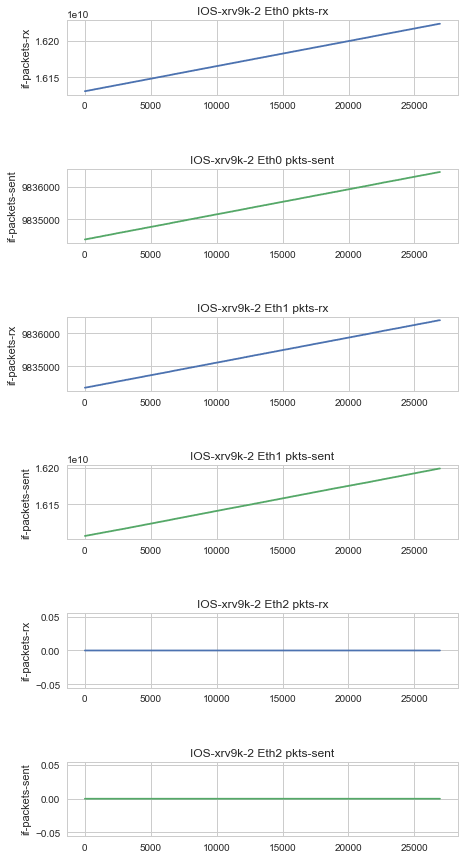

In [108]:
if PLOT == True:
    filename = './' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '-' + host + '-raw.png'
    
    plt.figure(figsize=(7,15))

    plt.subplot(6, 1, 1)
    plt.plot(telemetryDF.loc[(telemetryDF['host'] == host) & (telemetryDF['interface_name'] == 'GigabitEthernet0/0/0/0')]['packets-received'], 'b-')
    plt.title(host + ' Eth0 pkts-rx')
    plt.ylabel('if-packets-rx')
    
    plt.subplot(6, 1, 2)
    plt.plot(telemetryDF.loc[(telemetryDF['host'] == host) & (telemetryDF['interface_name'] == 'GigabitEthernet0/0/0/0')]['packets-sent'], 'g-')
    plt.title(host + ' Eth0 pkts-sent')
    plt.ylabel('if-packets-sent')
    
    plt.subplot(6, 1, 3)
    plt.plot(telemetryDF.loc[(telemetryDF['host'] == host) & (telemetryDF['interface_name'] == 'GigabitEthernet0/0/0/1')]['packets-received'], 'b-')
    plt.title(host + ' Eth1 pkts-rx')
    plt.ylabel('if-packets-rx')

    plt.subplot(6, 1, 4)
    plt.plot(telemetryDF.loc[(telemetryDF['host'] == host) & (telemetryDF['interface_name'] == 'GigabitEthernet0/0/0/1')]['packets-sent'], 'g-')
    plt.title(host + ' Eth1 pkts-sent')
    plt.ylabel('if-packets-sent')

    plt.subplot(6, 1, 5)
    plt.plot(telemetryDF.loc[(telemetryDF['host'] == host) & (telemetryDF['interface_name'] == 'GigabitEthernet0/0/0/2')]['packets-received'], 'b-')
    plt.title(host + ' Eth2 pkts-rx')
    plt.ylabel('if-packets-rx')

    plt.subplot(6, 1, 6)
    plt.plot(telemetryDF.loc[(telemetryDF['host'] == host) & (telemetryDF['interface_name'] == 'GigabitEthernet0/0/0/2')]['packets-sent'], 'g-')
    plt.title(host + ' Eth2 pkts-sent')
    plt.ylabel('if-packets-sent')
    
    plt.subplots_adjust(hspace=1)
    if SAVE_PLOT == True:
        plt.savefig(filename)
    if NOTEBOOK_PLOT == True:
        plt.show()

In [109]:
# Export the processed telemetry dataframe as a timestamped CSV
if SAVE_CSV == True:
    filename = ("%s-telemetry.csv" % datetime.datetime.now().strftime("%Y%m%d%H%M"))
    telemetryDF.to_csv(filename, header=True)

#### Calculate the packet deltas

In [110]:
# Add column with the number of interfaces for the host
telemetryDF['interface_count'] = telemetryDF.groupby('host')['interface_name'].transform('nunique')

In [111]:
if DEBUG == True:
    print telemetryDF.head()

In [112]:
# Filter on a per timestamp + host basis for metrics where all the expected interfaces are present
lossDF = telemetryDF.groupby(['timestamp', 'host'], as_index=False).filter(lambda x: len(x.interface_name) == min(x.interface_count))

In [113]:
if DEBUG == True:
    print lossDF.head(100)

In [114]:
# Aggregate the interface counts on a per timestamp + host basis
lossDF = lossDF.groupby(['timestamp', 'host'], as_index=False)['packets-received','packets-sent'].sum()

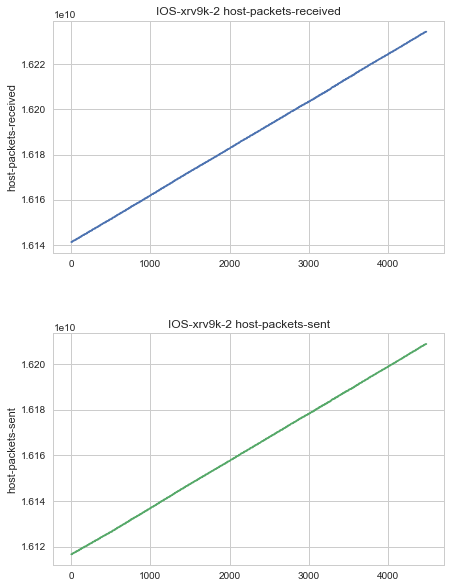

In [115]:
if PLOT == True:
    # Create per host aggregate plots
    filename = './' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '-' + host + '-aggregates.png'
    plt.figure(figsize=(7,10))

    plt.subplot(2, 1, 1)
    plt.plot(lossDF.loc[(lossDF['host'] == host)]['packets-received'], 'b-')
    plt.title(host + ' host-packets-received')
    plt.ylabel('host-packets-received')

    plt.subplot(2, 1, 2)
    plt.plot(lossDF.loc[(lossDF['host'] == host) ]['packets-sent'], 'g-')
    plt.title(host + ' host-packets-sent')
    plt.ylabel('host-packets-sent')

    plt.subplots_adjust(hspace=0.35)
    if SAVE_PLOT == True:
        plt.savefig(filename)
    if NOTEBOOK_PLOT == True:
        plt.show()

In [116]:
# Create the delta columns based on per host counts 
# TODO - need to calculate across 2+ samples to correct for sampling skew?
lossDF['delta-pkt-received'] = lossDF.groupby(['host'])['packets-received'].diff()
lossDF['delta-pkt-sent'] = lossDF.groupby(['host'])['packets-sent'].diff()

In [117]:
#lossDF['delta-multicast-received'] = lossDF.groupby(['host'])['multicast-packets-received'].diff()
#lossDF['delta-multicast-sent'] = lossDF.groupby(['host'])['multicast-packets-sent'].diff()
#lossDF['delta-bytes-in'] = lossDF.groupby(['host'])['bytes-in'].diff()
#lossDF['delta-bytes-out'] = lossDF.groupby(['host'])['bytes-out'].diff()

In [118]:
# Replace any NaN entries with zeros to keep the filter code happy
lossDF['delta-pkt-received'] = lossDF['delta-pkt-received'].replace(np.nan, 0)
lossDF['delta-pkt-sent'] = lossDF['delta-pkt-sent'].replace(np.nan, 0)

In [119]:
# Remove any redundant rows with zero delta counts
lossDF = lossDF[(lossDF['delta-pkt-received'] != 0) & (lossDF['delta-pkt-sent'] != 0)]

In [120]:
# Create the packet-loss column
lossDF['pkt-loss-raw'] = lossDF['delta-pkt-received'] - lossDF['delta-pkt-sent']

#### Normalize the delta packet counts

In [121]:
# Normalize the pkt-loss-raw into a new column
lossCol = lossDF['pkt-loss-raw']
lossDF['pkt-loss'] = (lossCol-lossCol.mean())/(lossCol.max()-lossCol.min())

In [122]:
# Export the loss dataframe as a timestamped CSV
if SAVE_CSV == True:
    filename = ("%s-loss.csv" % datetime.datetime.now().strftime("%Y%m%d%H%M"))
    lossDF.to_csv(filename, header=True)

#### Filter the dataframe for selected host

In [123]:
# Copy the complete dataframe to enable us to rerun the following cells with alternate host filters
if DEBUG == True:
    lossDFSaved = lossDF

In [124]:
# Filter the df for the selected host
lossDF = lossDF[lossDF['host'] == host]

In [125]:
if DEBUG == True:
    print lossDF.head()
    print "\nRow counts...\n%s" % lossDF.count()
print lossDF.columns

Index([u'timestamp', u'host', u'packets-received', u'packets-sent',
       u'delta-pkt-received', u'delta-pkt-sent', u'pkt-loss-raw', u'pkt-loss'],
      dtype='object')


#### Delta and packet loss plots for the selected host

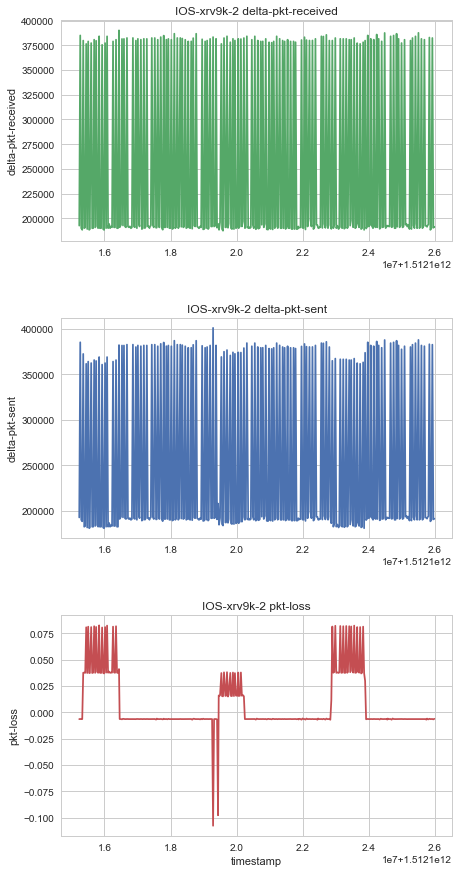

In [126]:
if PLOT == True:  
    filename = './' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '-' + host + '-deltas.png'
    t = lossDF['timestamp']
    
    plt.figure(figsize=(7,15))
    
    plt.subplot(3, 1, 1)
    plt.plot(t, lossDF['delta-pkt-received'], 'g-')
    plt.title(host + ' delta-pkt-received')
    plt.ylabel('delta-pkt-received')
    
    plt.subplot(3, 1, 2)
    plt.plot(t, lossDF['delta-pkt-sent'], 'b-')
    plt.title(host + ' delta-pkt-sent')
    plt.ylabel('delta-pkt-sent')
    
    plt.subplot(3, 1, 3)
    plt.plot(t, lossDF['pkt-loss'], 'r-')
    plt.title(host + ' pkt-loss')
    plt.xlabel('timestamp')
    plt.ylabel('pkt-loss')

    plt.subplots_adjust(hspace=0.35)
    if SAVE_PLOT == True:
        plt.savefig(filename)
    if NOTEBOOK_PLOT == True:
        plt.show()

#### Configure the LPF

LPF - low pass filter

In [127]:
# Setup the filter parameters - these will require tuning for ZTT telemetry
order = 3       # number of previous samples : 1st order = low roll-off
fs = 30         # sample rate
cutoff = 2      # desired cutoff frequency of the filter

In [128]:
# Butterworth (digital) low-pass filter to remove the high-frequency packet count discrepancies
# from http://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_fwbw_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    # Added padtype=None to prevent exception on sequences with samples < padlen
    y = filtfilt(b, a, data, padtype=None)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_fwbw_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

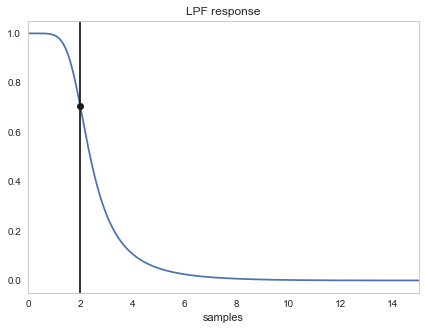

In [129]:
# Plot the low pass filter response
if PLOT == True:
    filename = './' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '-LPF-response.png'
    
    b, a = butter_lowpass(cutoff, fs, order)
    w, h = freqz(b, a, worN=8000)

    plt.figure(figsize=(7,5))

    plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title("LPF response")
    plt.xlabel('samples')
    
    plt.grid()
    if SAVE_PLOT == True:
        plt.savefig(filename)
    if NOTEBOOK_PLOT == True:
        plt.show()

#### Apply the filter to the calculated losses

In [130]:
# Run a 1st order lpf over the loss data - fw & bw to negate phase shift
lossDF['filter'] = butter_fwbw_lowpass_filter(lossDF['pkt-loss'], cutoff, fs, order)

In [131]:
# Debug - export the filter dataframe as a timestamped CSV
if SAVE_CSV == True:
    filename = ("%s-filter.csv" % datetime.datetime.now().strftime("%Y%m%d%H%M"))
    lossDF.to_csv(filename, header=True)

#### mu-sigma thresholding to identify black hole candidates

In [132]:
# number of samples in the window
#window_size = 30
window_size = 20

In [133]:
# number of std devs to trigger detection
threshold = 2

In [134]:
# Thresholding function (from John's XLS formula)
def black_hole_detect (fval, mval, sdval):
    if (abs(mval) > (threshold * sdval)):
        if (mval > 0):
            return 1
        else:
            return 0   # was -1 : mini-hack to prevent negative values in the output
    else:
        return 0

In [135]:
# Calculate the mean and stdev over a rolling window of samples
lossDF['mean'] = lossDF['filter'].rolling(window=window_size, center=True).mean()
lossDF['stdev'] = lossDF['filter'].rolling(window=window_size, center=True).std()

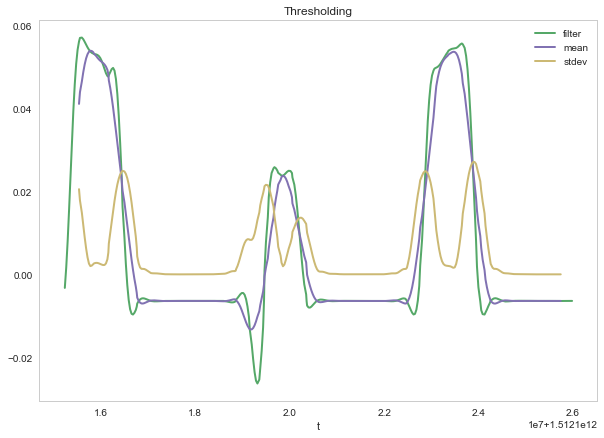

In [136]:
if PLOT == True:
    filename = './' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '-' + host + '-threshold.png'
    t = lossDF['timestamp']

    plt.figure(figsize=(10,7))

    # Replot the original pkt-loss, filtered pkt-loss and black hole candidate series    
    #plt.plot(t, lossDF['pkt-loss'], 'b-', label='pkt-loss')
    plt.plot(t, lossDF['filter'], 'g-', linewidth=2, label='filter')
    plt.plot(t, lossDF['mean'], 'm-', linewidth=2, label='mean')
    plt.plot(t, lossDF['stdev'], 'y-', linewidth=2, label='stdev')
    plt.title("Thresholding")
    plt.xlabel('t')
    plt.grid()
    plt.legend(loc=0)
    
    if SAVE_PLOT == True:
        plt.savefig(filename)
    if NOTEBOOK_PLOT == True:
        plt.show()

In [ ]:
# Identify black hole candidates in the filter output
lossDF['bhd'] = lossDF.apply(lambda x: black_hole_detect(x['filter'],x['mean'],x['stdev']), axis=1)

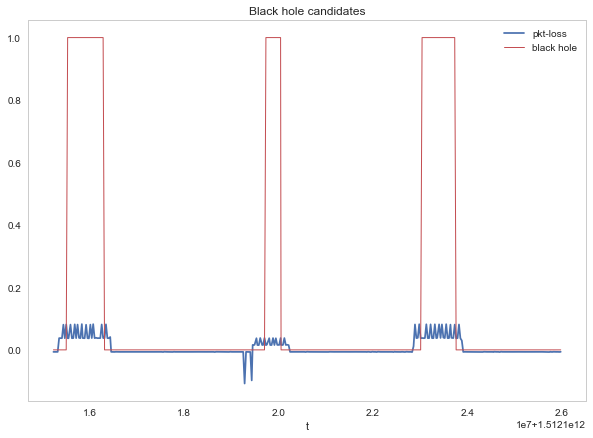

In [138]:
if PLOT == True:
    filename = './' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '-' + host + '-bhd.png'
    t = lossDF['timestamp']

    plt.figure(figsize=(10,7))

    # Replot the original pkt-loss, filtered pkt-loss and black hole candidate series    
    plt.plot(t, lossDF['pkt-loss'], 'b-', label='pkt-loss')
    plt.plot(t, lossDF['bhd'], 'r-', linewidth=1, label='black hole')
    plt.title("Black hole candidates")
    plt.xlabel('t')
    plt.grid()
    plt.legend(loc=0)
    
    if SAVE_PLOT == True:
        plt.savefig(filename)
    if NOTEBOOK_PLOT == True:
        plt.show()

In [139]:
if DEBUG == True:
    print lossDF.head(window_size*2)

#### Output the black hole indication and other metrics to CSV and OpenTSDB

In [140]:
if SAVE_CSV == True:
    filename = ("%s-black-hole.csv" % datetime.datetime.now().strftime("%Y%m%d%H%M"))
    lossDF.to_csv(filename, header=True)

In [141]:
# HTTP push of the input and output metrics to OpenTSDB 
import requests

def metrics_to_opentsdb(url, df):
    headers = {'content-type': 'application/json'}

    metrics = dict([('pkt.bhd', 'bhd'), ('pkt.filter', 'filter'), ('pkt.loss', 'pkt-loss'), 
                    ('pkt.delta.received','delta-pkt-received'), ('pkt.delta.sent','delta-pkt-sent')])
    
    for index, row in df.iterrows():
        for key, value in metrics.iteritems():
            data = {
                "metric": key,
                "timestamp": row["timestamp"],
                "value": row[value],
                "tags": {
                    "host": row["host"]
                }}
            r = requests.post(url, data=json.dumps(data), headers=headers)


In [142]:
if OpenTSDB_url:
    metrics_to_opentsdb(OpenTSDB_url, lossDF)

#### Simple normality testing: does the metric fit the normal distribution?

Let's look at the pkt-loss feature

In [143]:
k2, p = stats.normaltest(lossDF['pkt-loss'])

It is highly unlikely given our dataset is (a) small and (b) contains a set of synthesized packet losses...

In [144]:
if DEBUG == True:
    print("p = {:g}".format(p))
    print k2

In [ ]:
alpha = 1e-3   # set the null hypothesis threshold

if p < alpha:  # null hypothesis can not be rejected if the selected metric comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

### End of notebook